In [1]:
# !pip install einops==0.8.0 wandb==0.17.9

## <span style='color:#ff5f27'> 📝 Imports</span>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial
from torch.utils.tensorboard import SummaryWriter

from functions.t5 import encode_text
from functions.vqgan import load_vqgan_model, load_process_encode_rgb_image
import config

In [3]:
import wandb
wandb.login(key='287bb16bd939a26bd58a1fb72c38038e952d8e70')

wandb: Currently logged in as: maxxx. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/yarnapp/.netrc


True

## <span style='color:#ff5f27'> 🤖 Model Loading</span>

In [4]:
# Load COCO VQGAN
vqgan_model = load_vqgan_model(
    config.VQGAN_CONFIG_COCO,
    config.VQGAN_CHECKPOINT_COCO,
).to(config.DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-01-20T16-04-20_coco_transformer/coco_cond_stage.ckpt
2024-09-08 12:37:19,702 INFO: number of parameters: 6.513075e+08
Restored from logs/2021-01-20T16-04-20_coco_transformer/model_ckpt/last.ckpt
✅ Done!


## <span style='color:#ff5f27'> ⚙️ Text Encoding</span>

In [5]:
input_text = [
    config.PROMPT,
]

In [6]:
text_token_embeds, text_mask = encode_text(
    'A beautiful sunset over a city skyline.', 
    name='t5-large', 
    output_device=config.DEVICE,
)
text_token_embeds.shape

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([39, 3, 1024])

## <span style='color:#ff5f27'> 🗄️ Data Loader</span>

In [7]:
from functions.transistor import (
    TextImageDataset,
    collate_fn,
)

In [8]:
# Create dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = TextImageDataset(
    json_file='mc_coco/annotations/captions_val2017.json', 
    img_dir='mc_coco/val2017', 
    transform=transform,
)

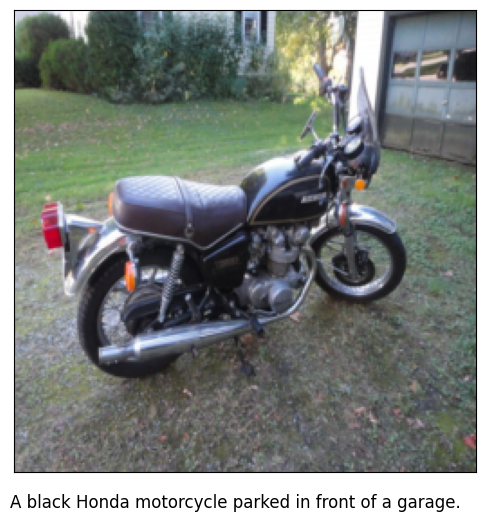

In [9]:
dataset.visualize_sample(0)

In [12]:
# # Split the validation dataset into training and validation subsets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size

# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# print(f"Total dataset size: {len(dataset)}")
# print(f"Training set size: {len(train_dataset)}")
# print(f"Validation set size: {len(val_dataset)}")

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)

In [13]:
from torch.utils.data import Subset

# Define the size of the subset you want to use
subset_size = 500  # Change this to the number of images you want to use

# Create a subset of the data
subset_indices = torch.randperm(len(dataset))[:subset_size]
subset_dataset = Subset(dataset, subset_indices)

# Split the subset into training and validation
train_size = int(0.8 * len(subset_dataset))
val_size = len(subset_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(subset_dataset, [train_size, val_size])

print(f"Full dataset size: {len(dataset)}")
print(f"Subset size: {len(subset_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)

Full dataset size: 25014
Subset size: 500
Training set size: 400
Validation set size: 100




## <span style='color:#ff5f27'> 🧬 Transistor Architecture</span>

In [14]:
class Transistor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Transistor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerTransistor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nhead=8, num_layers=6, dropout=0.1):
        super(TransformerTransistor, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, 
                                                    dim_feedforward=hidden_dim*4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LayerNorm(hidden_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.LayerNorm(hidden_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*2, output_dim)
        )
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.norm(x)
        x = x.squeeze(1)
        x = self.output_proj(x)
        return x.view(-1, 256, 16, 16)  # Reshape to VQGAN latent shape
        return self.model(x)

In [15]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerTransistor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nhead=8, num_layers=6, dropout=0.1):
        super(TransformerTransistor, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, 
                                                    dim_feedforward=hidden_dim*4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LayerNorm(hidden_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.LayerNorm(hidden_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*2, output_dim)
        )
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.norm(x)
        x = x.squeeze(1)
        x = self.output_proj(x)
        return x.view(-1, 256, 16, 16)  # Reshape to VQGAN latent shape

In [16]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"Early stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                print("Early stopping")
                self.early_stop = True

In [17]:
import torchvision
from functools import partial
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F

# Perceptual Loss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = torchvision.models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg[x])
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        h_x = x
        h_y = y
        h1_x = self.slice1(h_x)
        h1_y = self.slice1(h_y)
        h2_x = self.slice2(h1_x)
        h2_y = self.slice2(h1_y)
        h3_x = self.slice3(h2_x)
        h3_y = self.slice3(h2_y)
        h4_x = self.slice4(h3_x)
        h4_y = self.slice4(h3_y)
        return F.mse_loss(h1_x, h1_y) + F.mse_loss(h2_x, h2_y) + F.mse_loss(h3_x, h3_y) + F.mse_loss(h4_x, h4_y)

# Combined loss function
class CombinedLoss(nn.Module):
    def __init__(self, vqgan_model):
        super(CombinedLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.perceptual_loss = PerceptualLoss().to(config.DEVICE)
        self.vqgan_model = vqgan_model

    def forward(self, predicted_latents, target_latents):
        # Reshape latents to match VQGAN decoder input shape
        batch_size = predicted_latents.shape[0]
        predicted_latents = predicted_latents.view(batch_size, 256, 16, 16)
        target_latents = target_latents.view(batch_size, 256, 16, 16)

        mse_loss = self.mse_loss(predicted_latents, target_latents)
        
        # Decode latents to images
        predicted_images = self.vqgan_model.first_stage_model.decode(predicted_latents)
        target_images = self.vqgan_model.first_stage_model.decode(target_latents)
        
        perceptual_loss = self.perceptual_loss(predicted_images, target_images)
        
        # Combine losses (you can adjust the weights)
        total_loss = mse_loss + 0.1 * perceptual_loss
        
        return total_loss, mse_loss, perceptual_loss

## <span style='color:#ff5f27'> 🏃🏻‍♂️ Transistor Training</span>

In [18]:
@torch.no_grad()
def preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device):
    text_latents, _ = encode_text_fn(captions)
    text_latents = text_latents.mean(dim=1)  # Average over token dimension
    image_latents = []
    for img_path in img_paths:
        z, _ = load_process_encode_rgb_image(img_path, vqgan_model, device=device)
        image_latents.append(z)  # z should already be in shape [1, 256, 16, 16]
    image_latents = torch.cat(image_latents, dim=0)
    return text_latents.to(device), image_latents.to(device)

@torch.no_grad()
def validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn):
    transistor_model.eval()
    total_loss = 0.0
    total_mse_loss = 0.0
    total_perceptual_loss = 0.0
    for captions, _, img_paths in val_loader:
        text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
        outputs = transistor_model(text_latents)
        loss, mse_loss, perceptual_loss = criterion(outputs, image_latents)
        total_loss += loss.item()
        total_mse_loss += mse_loss.item()
        total_perceptual_loss += perceptual_loss.item()
    
    num_batches = len(val_loader)
    return (total_loss / num_batches, 
            total_mse_loss / num_batches, 
            total_perceptual_loss / num_batches)

In [19]:
def generate_image_from_text(user_query, transistor_model, vqgan_model, encode_text_fn, device, n_iterations=1):
    # Encode text
    text_latent, _ = encode_text_fn([user_query])
    text_latent = text_latent.mean(dim=1).to(device)  # Average over token dimension

    # Pass through Transistor
    with torch.no_grad():
        image_latent = transistor_model(text_latent)

    # Reshape
    image_latent = image_latent.view(1, 256, 16, 16)

    # Quantize (this step depends on VQGAN's specific implementation)
    c_code, _, [_, _, c_indices] = vqgan_model.first_stage_model.quantize(image_latent)
    
    print("c_code", c_code.shape, c_code.dtype)
    print("c_indices", c_indices.shape, c_indices.dtype)

    z_indices = torch.randint(256, c_indices.shape, device=vqgan_model.device)
    initial_image = vqgan_model.decode_to_img(z_indices, c_code.shape)

    print("Initial random image:")
    show_image(initial_image)

    for iteration in range(n_iterations):
        print(f"⛳️ Starting iteration {iteration + 1}/{n_iterations}")
        final_image = generate_iteration(
            vqgan_model, 
            c_code, 
            c_indices, 
            z_indices, 
            temperature=config.TEMPERATURE, 
            top_k=config.TOP_K, 
            update_every=config.UPDATE_EVERY,
            iteration=iteration,
        )

    print("✅ All iterations completed.")
    
    return final_image


In [20]:
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
from IPython.display import clear_output
from functions.utils import show_image, save_image
from functions.vqgan import generate_iteration
import os
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import os
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, epoch, save_dir='training'):
    plt.figure(figsize=(12, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, 'b-', label='Train Loss', marker='o', markersize=4, linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', marker='s', markersize=4, linewidth=2)

    plt.title(f'Training and Validation Loss Over Epochs (Epoch {epoch})', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(epochs)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()

    # Create the full directory path
    full_save_dir = os.path.join(save_dir, 'loss')
    
    # Create all directories in the path if they don't exist
    os.makedirs(full_save_dir, exist_ok=True)

    # Save the plot
    plt.savefig(os.path.join(full_save_dir, f'loss_plot.png'))
    plt.close()

# def train_model(transistor_model, train_loader, val_loader, vqgan_model, criterion, optimizer, device, num_epochs=50, accumulation_steps=2):
#     transistor_model.train()
#     scaler = torch.cuda.amp.GradScaler()
#     encode_text_fn = partial(encode_text, name='t5-large', output_device=device)
#     scheduler = OneCycleLR(optimizer, max_lr=0.001, epochs=num_epochs, steps_per_epoch=len(train_loader))
#     writer = SummaryWriter()
#     early_stopping = EarlyStopping(patience=10, min_delta=0.001)
    
#     train_losses = []
#     val_losses = []
    
#     best_val_loss = float('inf')
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
#         for i, (captions, _, img_paths) in enumerate(pbar):
#             text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
            
#             with torch.cuda.amp.autocast():
#                 outputs = transistor_model(text_latents)
#                 loss = criterion(outputs, image_latents)
            
#             scaler.scale(loss).backward()
            
#             if (i + 1) % accumulation_steps == 0:
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(transistor_model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()
#                 optimizer.zero_grad(set_to_none=True)
#                 scheduler.step()
            
#             running_loss += loss.item()
#             pbar.set_postfix({'loss': running_loss / (i + 1)})
        
#         avg_train_loss = running_loss / len(train_loader)
#         val_loss = validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn)

#         train_losses.append(avg_train_loss)
#         val_losses.append(val_loss)
        
#         print(f"⛳️ Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
#         writer.add_scalar('Loss/train', avg_train_loss, epoch)
#         writer.add_scalar('Loss/val', val_loss, epoch)
        
#         # Plot losses after each epoch
#         plot_losses(train_losses, val_losses, epoch + 1)
        
#         early_stopping(val_loss)
#         if early_stopping.early_stop:
#             print("⚠️ Early stopping triggered")
#             break
        
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(transistor_model.state_dict(), 'best_transistor_model.pth')
#             print(f"💾 Saved best model with validation loss: {best_val_loss:.4f}")
        
#         if (epoch + 1) % 5 == 0:
#             text = 'Beautiful green forest with a lot of green trees'
#             generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text_fn, device)
            
#             # Save generated image
#             save_image(generated_image, epoch + 1, sampling_folder='training', training=True)
                
#     writer.close()
#     print("✅ Training completed.")

In [21]:
def train_model(transistor_model, train_loader, val_loader, vqgan_model, criterion, optimizer, device, num_epochs=50, accumulation_steps=4):
    scaler = torch.cuda.amp.GradScaler()
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)
    
    encode_text_fn = partial(encode_text, name='t5-large', output_device=device)
    
    wandb.init(project="text-to-image-transistor", config={
        "learning_rate": optimizer.param_groups[0]['lr'],
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size * accumulation_steps,
        "accumulation_steps": accumulation_steps
    })
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        transistor_model.train()
        running_loss = 0.0
        running_mse_loss = 0.0
        running_perceptual_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        optimizer.zero_grad(set_to_none=True)
        
        for i, (captions, _, img_paths) in enumerate(pbar):
            text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
            
            with torch.cuda.amp.autocast():
                outputs = transistor_model(text_latents)
                loss, mse_loss, perceptual_loss = criterion(outputs, image_latents)
                loss = loss / accumulation_steps  # Normalize the loss because it is accumulated
            
            scaler.scale(loss).backward()
            
            running_loss += loss.item() * accumulation_steps
            running_mse_loss += mse_loss.item()
            running_perceptual_loss += perceptual_loss.item()
            
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(transistor_model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
            
            pbar.set_postfix({'loss': running_loss / (i + 1)})
        
        avg_train_loss = running_loss / len(train_loader)
        avg_train_mse_loss = running_mse_loss / len(train_loader)
        avg_train_perceptual_loss = running_perceptual_loss / len(train_loader)
        
        val_loss, val_mse_loss, val_perceptual_loss = validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn)
        print(f"⛳️ Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_mse_loss": avg_train_mse_loss,
            "train_perceptual_loss": avg_train_perceptual_loss,
            "val_loss": val_loss,
            "val_mse_loss": val_mse_loss,
            "val_perceptual_loss": val_perceptual_loss,
            "learning_rate": scheduler.get_last_lr()[0]
        })
        
        scheduler.step()
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("👮🏻‍♂️ Early stopping triggered")
            break
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(transistor_model.state_dict(), 'best_transistor_model.pth')
            print(f"💾 Saved best model with validation loss: {best_val_loss:.4f}")
        
        if (epoch + 1) % 5 == 0:
            text = 'Beautiful green forest with a lot of green trees'
            generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text_fn, device)
            wandb.log({"generated_image": wandb.Image(generated_image)})
    
    wandb.finish()
    print("✅ Training completed.")

In [22]:
# Dimension of T5 output
input_dim = 1024 

# Typically, transformer dimensions are powers of 2
hidden_dim = 1024

# Dimension of VQGAN latent space
output_dim = 256 * 16 * 16  

transistor_model = TransformerTransistor(
    input_dim, 
    hidden_dim, 
    output_dim, 
    nhead=8, 
    num_layers=6,
).to(config.DEVICE)

# Define loss function and optimizer
criterion = CombinedLoss(vqgan_model).to(config.DEVICE)
optimizer = torch.optim.AdamW(transistor_model.parameters(), lr=0.001, weight_decay=0.01)

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🕰️ Time: 16.89 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


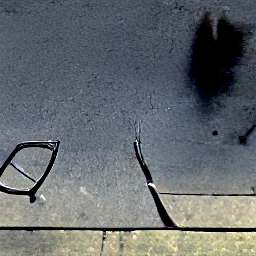

✅ All iterations completed.


Epoch 6/50: 100%|██████████| 25/25 [01:24<00:00,  3.36s/it, loss=2.74]


⛳️ Epoch [6/50], Train Loss: 2.7374, Val Loss: 2.7061
Early stopping counter: 3 out of 10


Epoch 7/50: 100%|██████████| 25/25 [01:33<00:00,  3.76s/it, loss=2.74]


⛳️ Epoch [7/50], Train Loss: 2.7427, Val Loss: 2.7208
Early stopping counter: 4 out of 10


Epoch 8/50: 100%|██████████| 25/25 [00:58<00:00,  2.36s/it, loss=2.74]


⛳️ Epoch [8/50], Train Loss: 2.7429, Val Loss: 2.7086
Early stopping counter: 5 out of 10


Epoch 9/50: 100%|██████████| 25/25 [01:02<00:00,  2.49s/it, loss=2.77]


⛳️ Epoch [9/50], Train Loss: 2.7738, Val Loss: 2.7302
Early stopping counter: 6 out of 10


Epoch 10/50:   8%|▊         | 2/25 [00:08<01:42,  4.44s/it, loss=2.81]


KeyboardInterrupt: 

In [23]:
# Train the model
train_model(
    transistor_model, 
    train_loader,
    val_loader,
    vqgan_model, 
    criterion,
    optimizer,
    config.DEVICE,
    num_epochs=50,
    accumulation_steps=4  # Makes my batch size 16 * 4 = 64
)

## <span style='color:#ff5f27'> 💾 Transistor Saving</span>

In [18]:
# # Save the trained model
# torch.save(transistor_model.state_dict(), 'final_transistor_model.pth')

---

## <span style='color:#ff5f27'> 🗄️ Transistor Loading</span>

In [19]:
def load_transistor_model(model_path):
    # Define model parameters
    input_dim = 1024  # Dimension of T5 output
    hidden_dim = 2048
    output_dim = 256 * 16 * 16  # Dimension of VQGAN latent space

    # Create model instance
    transistor_model = Transistor(input_dim, hidden_dim, output_dim).to(config.DEVICE)

    # Load the saved state dictionary
    transistor_model.load_state_dict(torch.load(model_path))

    # Set the model to evaluation mode
    transistor_model.eval()

    return transistor_model

# Usage
transistor_model = load_transistor_model('transistor/best_transistor_model.pth')

In [20]:
def visualize_results(transistor_model, vqgan_model, text_input, device, encode_text_fn):
    transistor_model.eval()
    with torch.no_grad():
        text_latent, _ = encode_text_fn([text_input])
        print(text_latent.shape)
        text_latent = text_latent.mean(dim=0).unsqueeze(0).to(device)  # Take mean and add batch dimension
        print(text_latent.shape)
        text_latent = text_latent.mean(dim=1).to(device)
        print(text_latent.shape)
        image_latent = transistor_model(text_latent)
        print(image_latent.shape)
        print(image_latent.view(1, 256, 16, 16))
        image = vqgan_model.first_stage_model.decode(image_latent.view(1, 256, 16, 16))
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title(text_input)
    plt.axis('off')
    plt.show()

torch.Size([1, 12, 1024])
torch.Size([1, 12, 1024])
torch.Size([1, 1024])
torch.Size([1, 65536])
tensor([[[[ 0.2568,  0.1385,  0.1997,  ...,  0.2738,  0.2820,  0.1843],
          [ 0.2770,  0.3261,  0.2516,  ...,  0.2018,  0.3252,  0.1260],
          [ 0.3146,  0.2942,  0.2519,  ...,  0.3051,  0.2447,  0.2868],
          ...,
          [ 0.3300,  0.3415,  0.3292,  ...,  0.3815,  0.3866,  0.3740],
          [ 0.3857,  0.2848,  0.2999,  ...,  0.3062,  0.2605,  0.2668],
          [ 0.3611,  0.2982,  0.2850,  ...,  0.3511,  0.3254,  0.3761]],

         [[ 0.0589,  0.0814,  0.0290,  ..., -0.0270,  0.0273,  0.1043],
          [ 0.0105,  0.0124,  0.0581,  ..., -0.0726, -0.0881,  0.0324],
          [ 0.0202, -0.0038, -0.0015,  ..., -0.0945,  0.0036, -0.0382],
          ...,
          [-0.0926, -0.0406, -0.0692,  ..., -0.0881, -0.0103, -0.0457],
          [-0.1039, -0.0270,  0.0401,  ..., -0.0007, -0.0287, -0.0671],
          [-0.0579, -0.0841, -0.0490,  ..., -0.0475, -0.0264, -0.0198]],

     

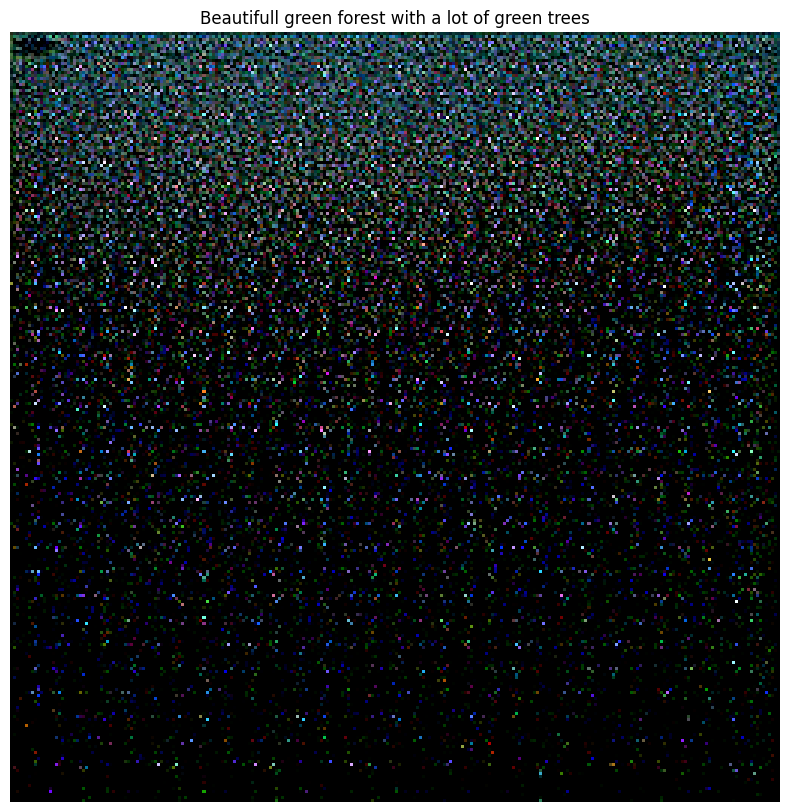

In [21]:
visualize_results(transistor_model, vqgan_model, "Beautifull green forest with a lot of green trees", config.DEVICE, encode_text)

---

In [144]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def initialize_z_from_segmentation(model, segmentation_tensor, visualize=True):
    """
    Initialize z and z_indices from a segmentation tensor.

    Args:
    model (torch.nn.Module): The VQGAN model.
    segmentation_tensor (torch.Tensor): One-hot encoded segmentation tensor [1, num_categories, height, width]
    visualize (bool): Whether to visualize the RGB representation of the segmentation.

    Returns:
    tuple: (z, z_indices)
        z (torch.Tensor): Encoded latent representation for z.
        z_indices (torch.Tensor): Indices from the quantized representation for z.
    """
    # Convert segmentation to RGB for z encoding
    segmentation_rgb = segmentation_to_rgb(segmentation_tensor)

    # Visualize the RGB representation if requested
    if visualize:
        visualize_rgb_segmentation(segmentation_rgb)

    # Encode the RGB representation to get z and z_indices
    z, _, [_, _, z_indices] = model.first_stage_model.encode(segmentation_rgb)

    print("z shape:", z.shape)
    print("z_indices shape:", z_indices.shape)

    return z, z_indices

def segmentation_to_rgb(segmentation_tensor):
    """
    Convert a one-hot encoded segmentation tensor to an RGB image.
    
    Args:
    segmentation_tensor (torch.Tensor): One-hot encoded segmentation tensor [1, num_categories, height, width]
    
    Returns:
    torch.Tensor: RGB tensor [1, 3, height, width]
    """
    # Remove batch dimension and move to CPU
    seg = segmentation_tensor.squeeze(0).cpu().numpy()
    
    # Get the index of the maximum value along the category dimension
    seg_argmax = np.argmax(seg, axis=0)
    
    # Create a color map (you might want to define specific colors for each category)
    color_map = np.random.randint(0, 256, (seg.shape[0], 3), dtype=np.uint8)
    
    # Map the segmentation to RGB
    rgb_image = color_map[seg_argmax]
    
    # Convert to torch tensor and add batch dimension
    rgb_tensor = torch.from_numpy(rgb_image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    
    # Move to the same device as the model
    rgb_tensor = rgb_tensor.to(segmentation_tensor.device)
    
    return rgb_tensor

def visualize_rgb_segmentation(rgb_tensor):
    """
    Visualize the RGB representation of the segmentation.

    Args:
    rgb_tensor (torch.Tensor): RGB tensor [1, 3, height, width]
    """
    # Move tensor to CPU and convert to numpy array
    rgb_np = rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Clip values to [0, 1] range
    rgb_np = np.clip(rgb_np, 0, 1)

    # Create a new figure
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_np)
    plt.axis('off')
    plt.title('RGB Representation of Segmentation')
    plt.show()

⛳️ Number of categories in segmentation image: 256
⛳️ Segmentation tensor shape: torch.Size([1, 183, 640, 480])


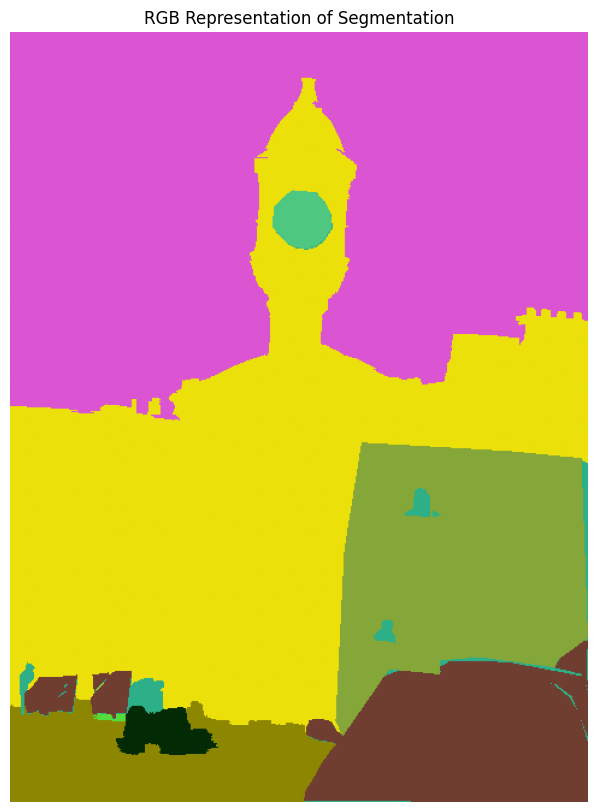

z shape: torch.Size([1, 256, 40, 30])
z_indices shape: torch.Size([1200])


In [145]:
segmentation_tensor = load_and_process_segmentation(
    config.INITIAL_IMAGE, 
    plot_segmentation=False, 
)
    
# Example usage:
z, z_indices = initialize_z_from_segmentation(vqgan_model, segmentation_tensor, visualize=True)

---

In [146]:
from functions.utils import(
    show_image
)
import config
from functions.vqgan import generate_iteration, load_and_process_segmentation

In [147]:
config.INITIAL_IMAGE = f"data/coco_segmentations/000000098392.png"

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def initialize_from_segmentation(model, segmentation_path, num_categories_expected=183, device='cuda', visualize=True):
    """
    Initialize both z and c from a segmentation mask.

    Args:
    model (torch.nn.Module): The VQGAN model.
    segmentation_path (str): Path to the segmentation image.
    num_categories_expected (int): Number of categories the model expects.
    device (str): Device to use for tensor operations.
    visualize (bool): Whether to visualize the RGB representation of the segmentation.

    Returns:
    tuple: (z, z_indices, c_code, c_indices)
        z (torch.Tensor): Encoded latent representation for z.
        z_indices (torch.Tensor): Indices from the quantized representation for z.
        c_code (torch.Tensor): Encoded conditional code.
        c_indices (torch.Tensor): Indices from the quantized representation for c.
    """
    # Load and process the segmentation mask
    segmentation_tensor = load_and_process_segmentation(
        segmentation_path,
        plot_segmentation=True,
        num_categories_expected=num_categories_expected,
        device=device
    )

    # Encode the segmentation to get c_code and c_indices
    c_code, c_indices = model.encode_to_c(segmentation_tensor)

    # Convert segmentation to RGB for z encoding
    segmentation_rgb = segmentation_to_rgb(segmentation_tensor)

    # Visualize the RGB representation if requested
    if visualize:
        visualize_rgb_segmentation(segmentation_rgb)

    # Encode the RGB representation to get z and z_indices
    z, _, [_, _, z_indices] = model.first_stage_model.encode(segmentation_rgb)

    print("z shape:", z.shape)
    print("z_indices shape:", z_indices.shape)
    print("c_code shape:", c_code.shape)
    print("c_indices shape:", c_indices.shape)

    return z, z_indices, c_code, c_indices

def segmentation_to_rgb(segmentation_tensor):
    """
    Convert a one-hot encoded segmentation tensor to an RGB image.
    
    Args:
    segmentation_tensor (torch.Tensor): One-hot encoded segmentation tensor [1, num_categories, height, width]
    
    Returns:
    torch.Tensor: RGB tensor [1, 3, height, width]
    """
    # Remove batch dimension and move to CPU
    seg = segmentation_tensor.squeeze(0).cpu().numpy()
    
    # Get the index of the maximum value along the category dimension
    seg_argmax = np.argmax(seg, axis=0)
    
    # Create a color map (you might want to define specific colors for each category)
    color_map = np.random.randint(0, 256, (seg.shape[0], 3), dtype=np.uint8)
    
    # Map the segmentation to RGB
    rgb_image = color_map[seg_argmax]
    
    # Convert to torch tensor and add batch dimension
    rgb_tensor = torch.from_numpy(rgb_image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    
    # Move to the same device as the model
    rgb_tensor = rgb_tensor.to(segmentation_tensor.device)
    
    return rgb_tensor

def visualize_rgb_segmentation(rgb_tensor):
    """
    Visualize the RGB representation of the segmentation.

    Args:
    rgb_tensor (torch.Tensor): RGB tensor [1, 3, height, width]
    """
    # Move tensor to CPU and convert to numpy array
    rgb_np = rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Clip values to [0, 1] range
    rgb_np = np.clip(rgb_np, 0, 1)

    # Create a new figure
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_np)
    plt.axis('off')
    plt.title('RGB Representation of Segmentation')
    plt.show()

# Example usage:
z, z_indices, c_code, c_indices = initialize_from_segmentation(vqgan_model, config.INITIAL_IMAGE, visualize=False)

🕰️ Time: 16.44 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


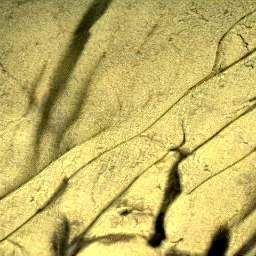

✅ All iterations completed.


In [173]:
text = 'Beautifull green forest with a lot of green trees'

generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE)

🕰️ Time: 16.59 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


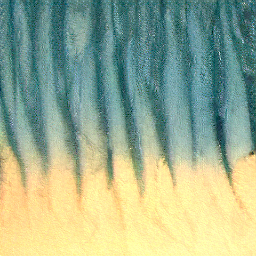

✅ All iterations completed.


In [174]:
text = 'Blue ocean with blue waves'

generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE)

🕰️ Time: 16.61 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


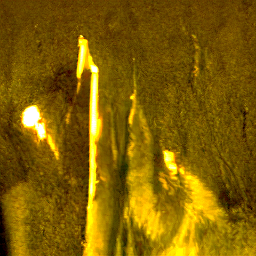

✅ All iterations completed.


In [181]:
text = 'Yellow beautiful flower'

generate_image_from_text(text, transistor_model, vqgan_model, encode_text, config.DEVICE)

---